In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.io import arff
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix

from typing import Optional
import json

os.environ["OMP_NUM_THREADS"] = '1'

print(
"TensorFlow version:", tf.__version__)
print("Num GPUs Available", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available 1


## EDA

In [3]:
# Load .arff file
data, meta = arff.loadarff('dataset/Dry_Bean_Dataset.arff')
df = pd.DataFrame(data)

# Convert binary string to readable format for the 'Class' column
df['Class'] = df['Class'].apply(lambda x: x.decode('utf-8'))

# Basic Data Info
print(df.info())  # check data types and ensure correct loading
print(df['Class'].value_counts())  # check class distribution

# Display the first few rows to understand feature values and ranges
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  float64
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  float64
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [4]:
df.drop(columns=['ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4'], axis=1, inplace=True)

In [5]:
# Mean Imputation
def mean_imputation(df: pd.DataFrame) -> pd.DataFrame:
    """Impute missing values with the mean of each column."""
    imputed_df = df.copy()
    return imputed_df.fillna(imputed_df.mean())

# Median Imputation
def median_imputation(df: pd.DataFrame) -> pd.DataFrame:
    """Impute missing values with the median of each column."""
    imputed_df = df.copy()
    return imputed_df.fillna(imputed_df.median())

# Mode Imputation
def mode_imputation(df: pd.DataFrame) -> pd.DataFrame:
    """Impute missing values with the mode (most frequent value) of each column."""
    imputed_df = df.copy()
    for column in imputed_df.columns:
        mode_val = imputed_df[column].mode()[0]
        imputed_df[column].fillna(mode_val, inplace=True)
    return imputed_df

# K-Nearest Neighbors (KNN) Imputation
def knn_imputation(df: pd.DataFrame, n_neighbors: int = 5) -> pd.DataFrame:
    """Impute missing values using K-Nearest Neighbors."""
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_array = imputer.fit_transform(df)
    return pd.DataFrame(imputed_array, columns=df.columns)

# Constant Imputation
def constant_imputation(df: pd.DataFrame, fill_value: Optional[float] = 0) -> pd.DataFrame:
    """Impute missing values with a constant value (default is 0)."""
    imputed_df = df.copy()
    return imputed_df.fillna(fill_value)

def drop_na(df: pd.DataFrame) -> pd.DataFrame:
    imputed_df = df.copy()
    return imputed_df.dropna()

imputed_df = df.copy()


In [6]:
def plot_bean_counts(df, bean_column='Class'):
    """Plot the count of each bean type."""
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=bean_column, palette='viridis')
    plt.title("Count of Each Bean Type")
    plt.xlabel("Bean Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

def plot_bean_pairplot(df, bean_column='Class', features=None):
    """
    Plot pairwise relationships for the specified features and color by bean type.
    """
    if features is None:
        features = df.select_dtypes(include='number').columns.tolist()[:5]  # Select first 5 numerical features by default
    sns.pairplot(df, vars=features, hue=bean_column, palette='viridis', plot_kws={'alpha': 0.5})
    plt.suptitle("Pair Plot of Selected Features by Bean Type", y=1.02)
    plt.show()

def plot_bean_pca(df, bean_column='Class'):
    """
    Perform PCA to reduce dimensions to 2D and plot the beans in 2D space.
    """
    features = df.select_dtypes(include='number').columns.tolist()
    X = df[features]
    y = df[bean_column]

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', alpha=0.7)
    plt.title("PCA Plot of Beans (2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title=bean_column)
    plt.show()

def plot_bean_boxplot(df, bean_column='Class', feature='feature_name'):
    """
    Plot a box plot for a specific feature across different bean types.
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=bean_column, y=feature, palette='viridis')
    plt.title(f"Distribution of {feature} by Bean Type")
    plt.xlabel("Bean Type")
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()

def plot_bean_violinplot(df, bean_column='Class', feature='feature_name'):
    """
    Plot a violin plot for a specific feature across different bean types.
    """
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, x=bean_column, y=feature, palette='viridis')
    plt.title(f"Violin Plot of {feature} by Bean Type")
    plt.xlabel("Bean Type")
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()



In [7]:
def plot_corr_matrix(df: pd.DataFrame) -> pd.DataFrame:
    # Generate correlation matrix
    correlation_matrix = df.drop(columns=['Class']).corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with a color bar
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title("Feature Correlation Matrix")
    plt.show()


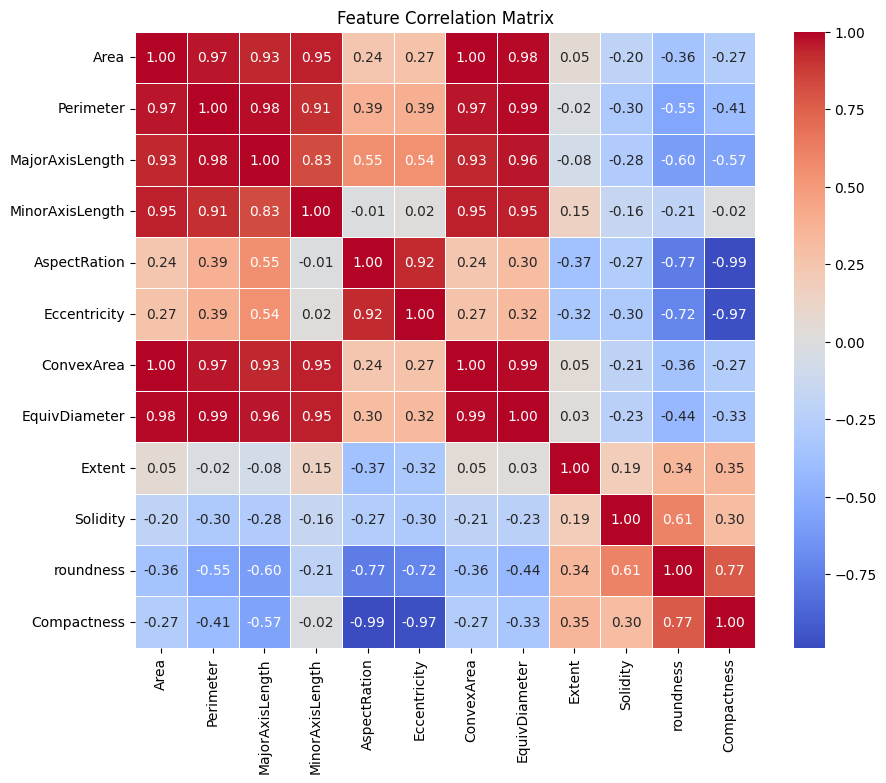

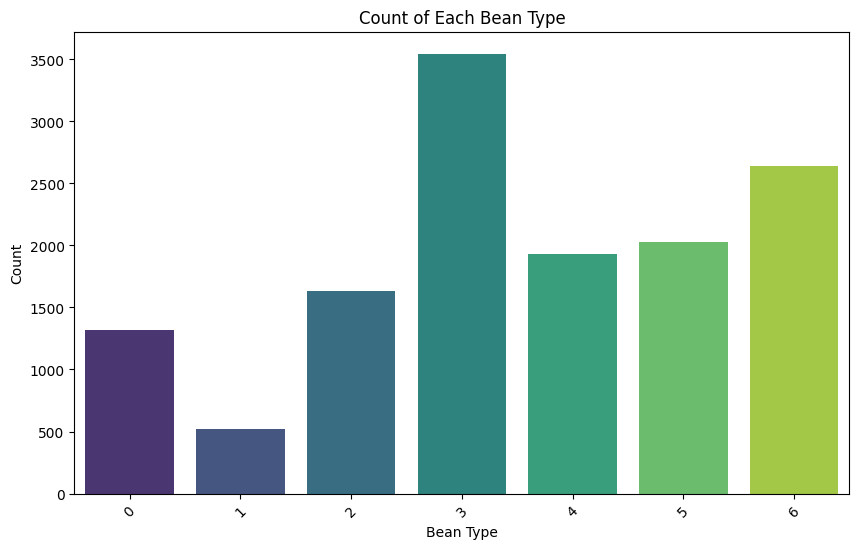

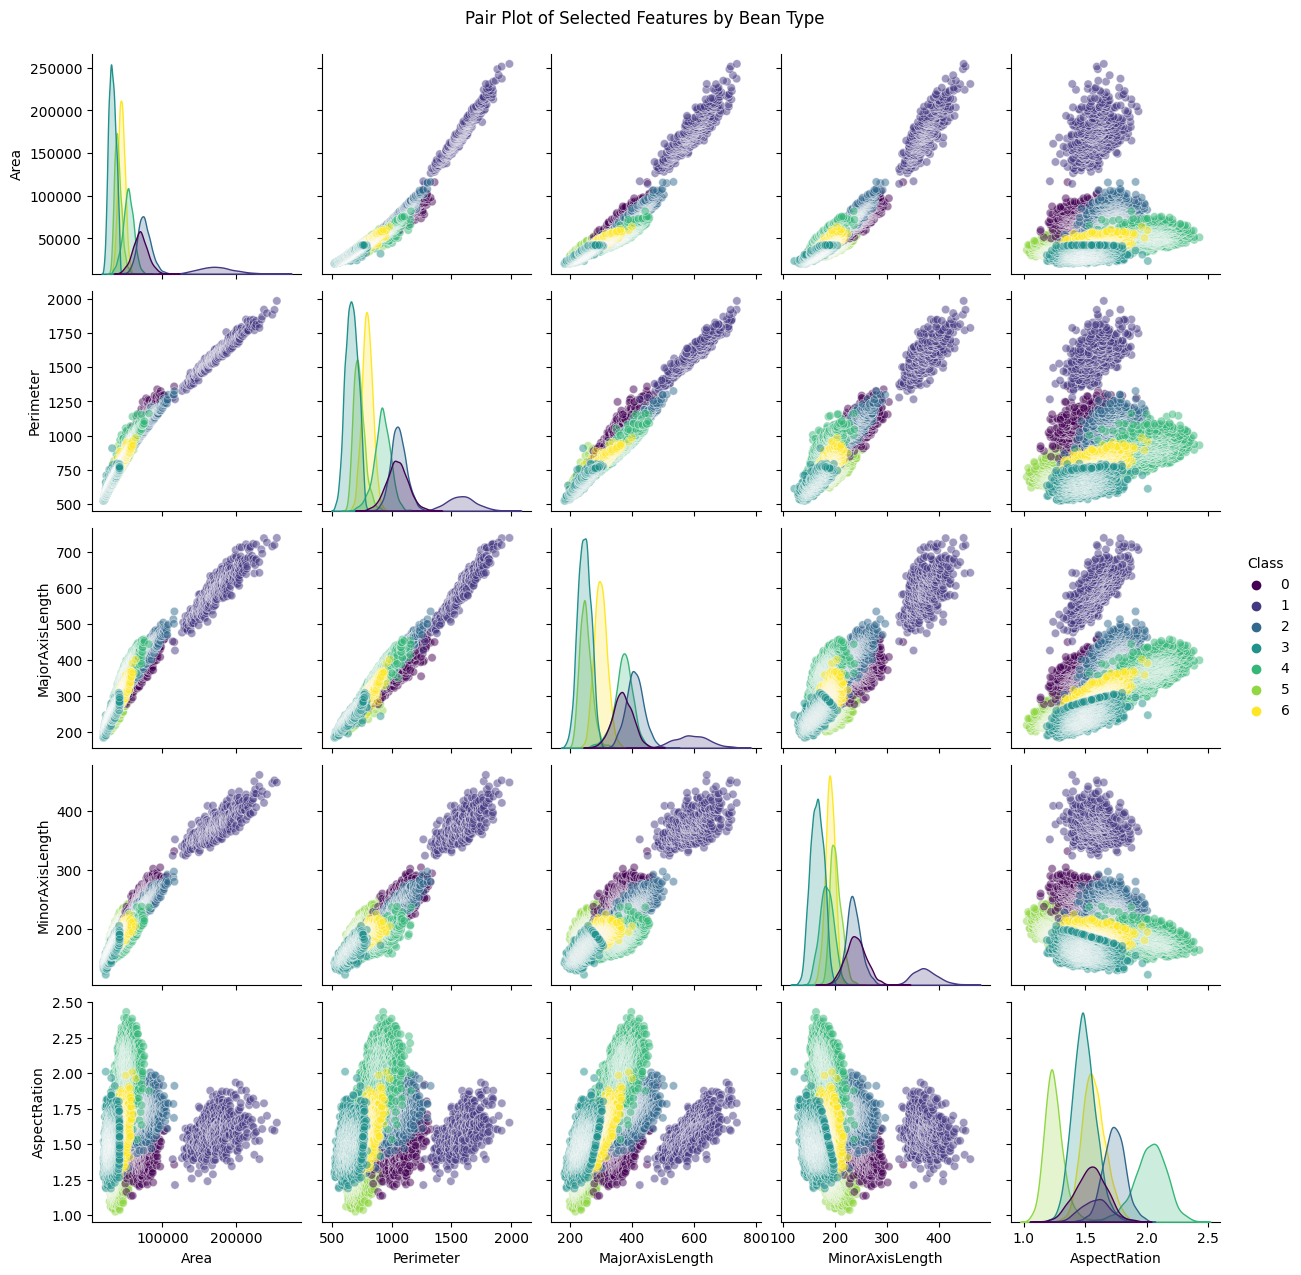

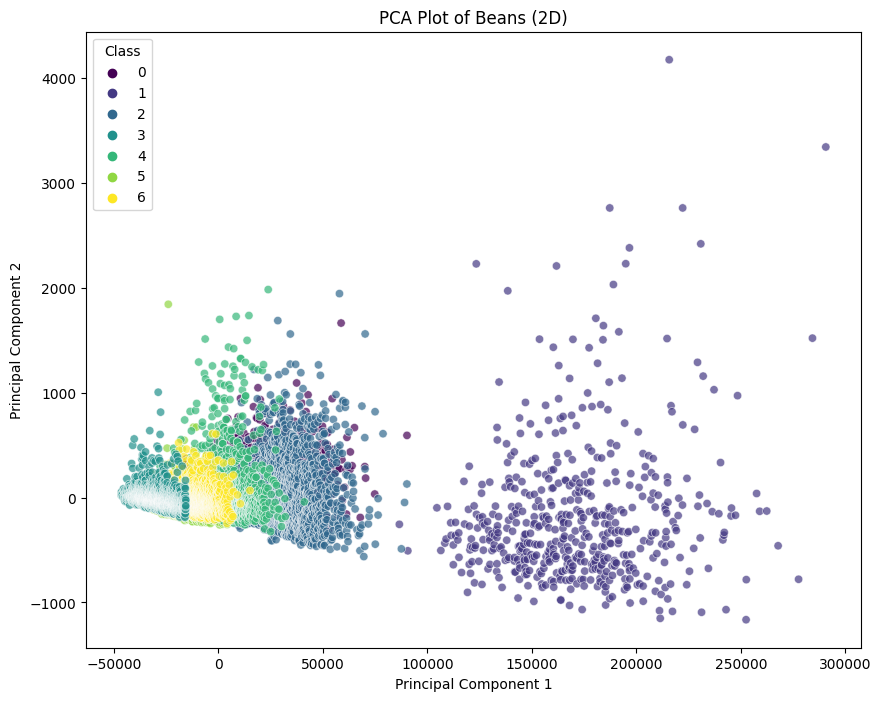

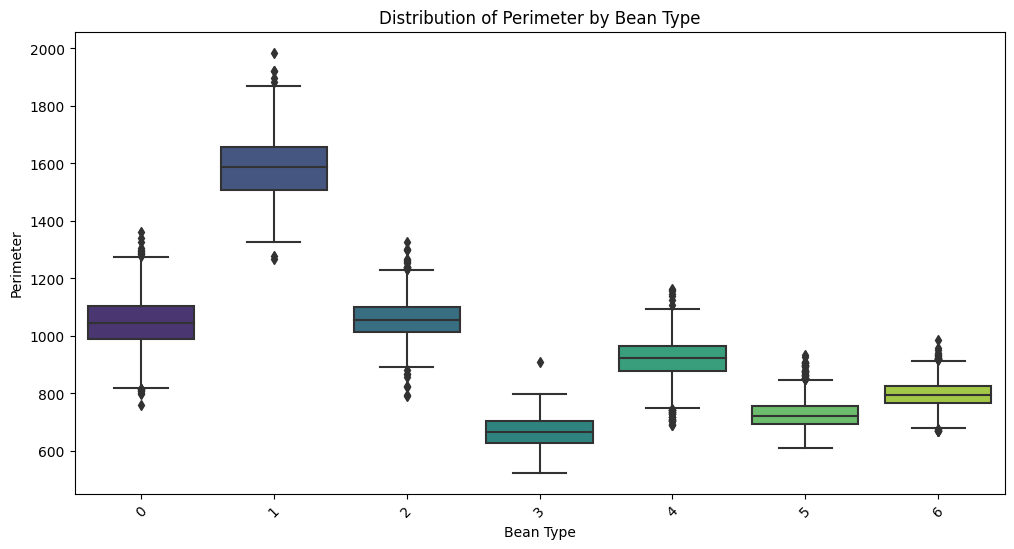

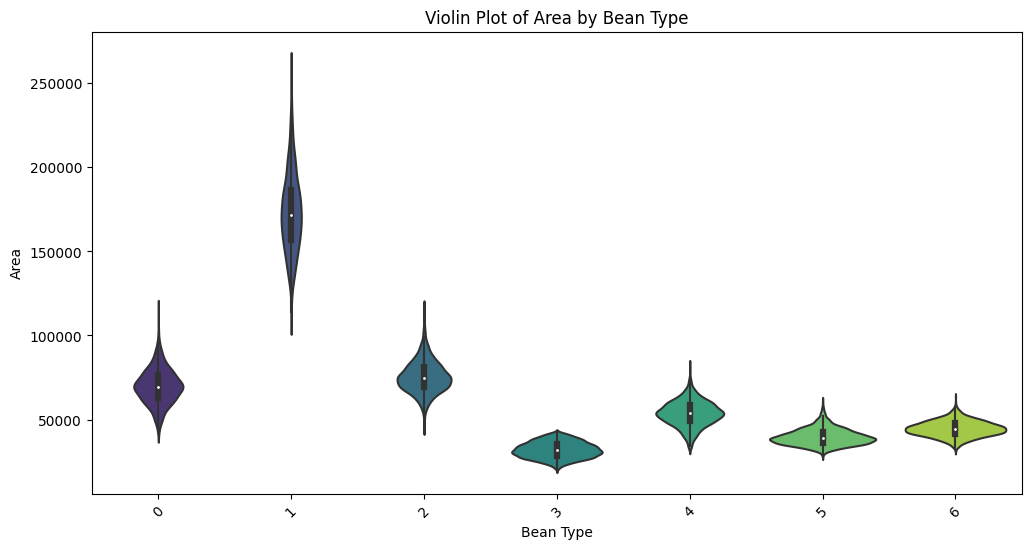

In [20]:
plot_corr_matrix(imputed_df)
plot_bean_counts(imputed_df)
plot_bean_pairplot(imputed_df)
plot_bean_pca(imputed_df)
plot_bean_boxplot(imputed_df, feature='Perimeter')
plot_bean_violinplot(imputed_df, feature='Area')


---
---
---

In [ ]:
# Encode the target variable
label_encoder = LabelEncoder()
imputed_df['Class'] = label_encoder.fit_transform(imputed_df['Class'])

# Separate features and target variable
X = imputed_df.drop(columns=['Class'])
y = imputed_df['Class']

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the feature columns (use fit on train, transform on both train and test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Normal Model

In [29]:
# Define the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(7, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model with categorical loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to inspect layer structure
model.summary()

Model: "sequential_439"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1756 (Dense)          (None, 64)                832       
                                                                 
 dense_1757 (Dense)          (None, 32)                2080      
                                                                 
 dense_1758 (Dense)          (None, 16)                528       
                                                                 
 dense_1759 (Dense)          (None, 7)                 119       
                                                                 
Total params: 3,559
Trainable params: 3,559
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions (returns class probabilities, take argmax to get class labels)
y_pred = model.predict(X_test).argmax(axis=1)

Epoch 1/50
273/273 [==============================] - 1s 2ms/step - loss: 0.7382 - accuracy: 0.7759 - val_loss: 0.3184 - val_accuracy: 0.9022
Epoch 2/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2771 - accuracy: 0.9041 - val_loss: 0.2445 - val_accuracy: 0.9146
Epoch 3/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2421 - accuracy: 0.9108 - val_loss: 0.2355 - val_accuracy: 0.9206
Epoch 4/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2297 - accuracy: 0.9168 - val_loss: 0.2149 - val_accuracy: 0.9206
Epoch 5/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2220 - accuracy: 0.9194 - val_loss: 0.2126 - val_accuracy: 0.9256
Epoch 6/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2206 - accuracy: 0.9200 - val_loss: 0.2136 - val_accuracy: 0.9224
Epoch 7/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2199 - accuracy: 0.9227 - val_loss: 0.2112 - val_accuracy: 0.9206
Epoch 

In [32]:
filename = "First"
path = "models/"

model.save(path + filename + "_model.h5")

with open(path + filename + "_history.json", "w") as f:
    json.dump(history.history, f)

## Grid Search

In [10]:
class HistorySaver(Callback):
    def __init__(self):
        super().__init__()
        self.history = None

    def on_train_end(self, logs=None):
        # Store the history after each model finishes training
        self.history = self.model.history.history

In [11]:
def create_model(learning_rate=0.001, activation='relu', neurons=64):
    model = Sequential([
        Dense(neurons, activation=activation, input_shape=(X_train.shape[1],)),
        Dense(neurons // 2, activation=activation),
        Dense(neurons // 4, activation=activation),
        Dense(7, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
param_grid = {
    'learning_rate': [0.001, 0.01],
    'activation': ['relu'],
    'neurons': [64, 128, 256],
    'batch_size': [32, 64],
    'epochs': [30, 40, 50]
}

In [21]:
# Set up early stopping and history saver callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_saver = HistorySaver()

# Wrap the model in KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Initialize GridSearchCV with StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')

# Perform the grid search with the callbacks; `validation_split` to mimic a validation set in each fold
fit_params = {
    'callbacks': [early_stopping, history_saver],
    'validation_split': 0.2  # 20% of each fold’s training data will be used for validation
}

grid_result = grid.fit(X_train, y_train, **fit_params)

C:\Users\rasmu\AppData\Local\Temp\ipykernel_35228\1996014543.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


KeyboardInterrupt: 

In [14]:
# Print the best parameters and accuracy
print("Best Parameters: ", grid_result.best_params_)
print(f"Best Accuracy: {grid_result.best_score_ * 100:.2f}%")

# Best model with optimal hyperparameters
model = grid_result.best_estimator_.model
history = history_saver.history

Best Parameters:  {'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001, 'neurons': 64}
Best Accuracy: 92.53%


In [15]:
filename = "best_relu"
path = "models/"

model.save(path + filename + "_model.h5")

with open(path + filename + "_history.json", "w") as f:
    json.dump(history, f)

## Evaluating

In [16]:
model = load_model(path + "best_relu_model.h5")

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


86/86 [==============================] - 0s 2ms/step - loss: 0.2276 - accuracy: 0.9170
Test Accuracy: 0.9170


In [18]:
# Making predictions
predictions = model.predict(X_test)
predicted_classes = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Display predictions
print(predicted_classes)

# Get predicted classes from the prediction probabilities
y_pred = predictions.argmax(axis=1)


86/86 [==============================] - 0s 1ms/step
['DERMASON' 'BOMBAY' 'SIRA' ... 'HOROZ' 'CALI' 'DERMASON']


In [19]:
# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.94      0.87      0.90       265
      BOMBAY       1.00      0.99      1.00       104
        CALI       0.92      0.93      0.92       326
    DERMASON       0.92      0.91      0.92       709
       HOROZ       0.96      0.94      0.95       386
       SEKER       0.92      0.95      0.93       406
        SIRA       0.86      0.88      0.87       527

    accuracy                           0.92      2723
   macro avg       0.93      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723

